In [1]:
# https://pytorch.org/tutorials/advanced/neural_style_tutorial.html
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
from torchvision.models import vgg19, VGG19_Weights

import copy

In [2]:
# set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)

In [3]:
device

device(type='cuda')

In [4]:
# Load the image

# desired size of the output image
imsize = 512 if torch.cuda.is_available() else 128  # use small size if no GPU

loader = transforms.Compose([
    transforms.Resize(imsize),  # scale imported image to imsize (a maybe smaller square image)
    transforms.ToTensor()])  # transform it into a torch tensor


def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


style_img = image_loader("./images/picasso.jpg")
content_img = image_loader("./images/dancing.jpg")

assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

In [6]:
# See how the unsqueeze(0) is changing the image (it actually add additional dimension at position 0)
# shape [3, 512, 512] -> [1, 3, 512, 512]
image_tst1 = Image.open("./images/picasso.jpg")
image_tst1 = loader(image_tst1)
print(f"shape before unsqueeze", image_tst1.shape)
image_tst1 = image_tst1.unsqueeze(0)
print(f"shape after unsqueeze", image_tst1.shape)

shape before unsqueeze torch.Size([3, 512, 512])
shape after unsqueeze torch.Size([1, 3, 512, 512])


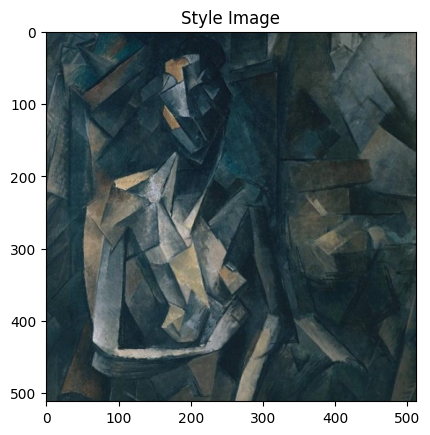

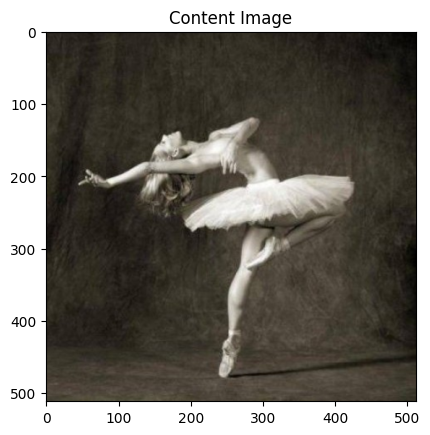

In [7]:
# Display the image in the notebook in PIL image format

unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated


plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

## Loss Function

Let C be the Content Image, G be the New Generated Image, and S be the Style Image
Let \[l] be the layer l
Let a, b be two hyperparameters which control the two terms (if a gets larger, the G will be more similar to the content image).

$J_{all loss}(C, S, G) = a * $J_{content}(C, G) + b * $J_{style}(S, G)$

### Content Loss

$J_{content}(C, G) = 0.5 * ||{a}^{[l] (c)} - {a}^{ [l] (G) }||^2$

This is the element-wise difference of layer l activation output between the content image and generated image. 0.5 is a normalization term. The later is the squared L2 norm.

### Style Loss

Let i, j, k be indices in dimensions represent height h, width w, and channel c respectively.
Let $G^{[l]}, dim = {n_c}^{[l]} * {n_c}^{[l]}$ be the matrix measures how across channel values differ.

$G_{kk^{'}}^{[l](S)} = \sum_{i=1}^{nh^{[l]}} \sum_{j=1}^{nw^{[l]}} a_{ijk}^{[l](S)} a_{ijk^{'}}^{[l](S)}$, where k and $k^'$ range from 1 to $nc^{[l]}$

This term measures in the Style Image, across all heights and widths of layer l output, how each pairs of different channel vary.

$G_{kk^{'}}^{[l](G)} = \sum_{i=1}^{nh^{[l]}} \sum_{j=1}^{nw^{[l]}} a_{ijk}^{[l](G)} a_{ijk^{'}}^{[l](G)}$, where k and $k^'$ range from 1 to $nc^{[l]}$

This term measures in the Generated Image, across all heights and widths of layer l output, how each pairs of different channel vary.

$J_{style}(S, G) = \frac{1}{(2 * nh^{[l]} nw^{[l]} nc^{[l]})^2} * \sum_{k} \sum_{k^{'}} (G_{kk^{'}}^{[l](S)} - G_{kk^{'}}^{[l](G)})^2$

This final layer style cost function is the difference between these two matrices above (sum of squared of element-wise differences), weighted by the normalization constant.

in layer l, the style could be defined as correlation between activations across channels. Imagine has an layer l output shape in nh * nw (height * width) * nc (# of channels), we try to see every same nh * nw location correlation across different channels.

$J_{sum style loss}(S, G) = \sum_{l} \lambda^{[l]} J_{style}^{[l]}(S, G)$

The final style cost function sums all the layers.

In [8]:
# Loss Functions
"""
The loss functions consist of two parts: content loss and style loss. The content loss calculates how similar the new image resembles the content image, and the style loss calculates how similar the new image's style resembles the style image.
"""

class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resize F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)


class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

In [9]:
# Import a pretrained neural network

cnn = vgg19(weights=VGG19_Weights.DEFAULT).features.eval()

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to C:\Users\harol/.cache\torch\hub\checkpoints\vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:13<00:00, 42.8MB/s] 


In [10]:
# Do normalization because VGG networks are trained on images with each channel normalized by mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225]. We will use them to normalize the image before sending it into the network.

cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406])
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225])

# create a module to normalize input image, so we can easily put it in a
# ``nn.Sequential``
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize ``img``
        return (img - self.mean) / self.std

In [11]:
# Modify the original VGG layer to add content loss and style loss layers
# calculate the loss by intercepting intermediate outputs and send to loss layers

# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    # normalization module
    normalization = Normalization(normalization_mean, normalization_std)

    # just in order to have an iterable access to or list of content/style
    # losses
    content_losses = []
    style_losses = []

    # assuming that ``cnn`` is a ``nn.Sequential``, so we make a new ``nn.Sequential``
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ``ContentLoss``
            # and ``StyleLoss`` we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

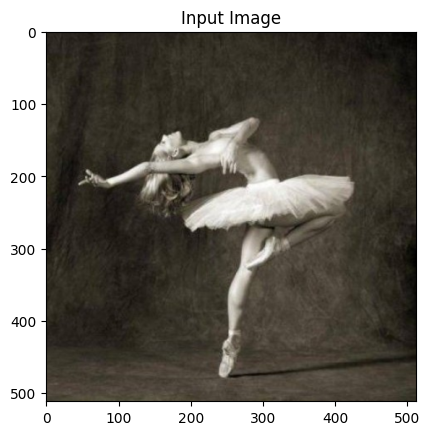

In [12]:
input_img = content_img.clone()
# if you want to use white noise by using the following code:
#
# .. code-block:: python
#
#    input_img = torch.randn(content_img.data.size())

# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')

In [13]:
# Train and Gradient Descent

def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img])
    return optimizer

In [14]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)

    # We want to optimize the input and not the model parameters so we
    # update all the requires_grad fields accordingly
    input_img.requires_grad_(True)
    # We also put the model in evaluation mode, so that specific layers
    # such as dropout or batch normalization layers behave correctly.
    model.eval()
    model.requires_grad_(False)

    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            with torch.no_grad():
                input_img.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    with torch.no_grad():
        input_img.clamp_(0, 1)

    return input_img

Building the style transfer model..


C:\Users\harol\.pyenv\pyenv-win\versions\3.10.6\lib\site-packages\torch\utils\_device.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)


Optimizing..
run [50]:
Style Loss : 4.203011 Content Loss: 4.125096

run [100]:
Style Loss : 1.133540 Content Loss: 3.024891

run [150]:
Style Loss : 0.704920 Content Loss: 2.638694

run [200]:
Style Loss : 0.476494 Content Loss: 2.487736

run [250]:
Style Loss : 0.348079 Content Loss: 2.402922

run [300]:
Style Loss : 0.266443 Content Loss: 2.348249



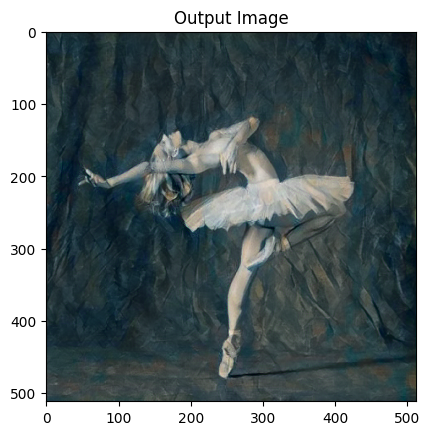

In [15]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)

plt.figure()
imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()